In [304]:
# import necessary libraries
import numpy as np
import pandas as pd
import tensorflow as tf
import matplotlib.pyplot as plt
import seaborn as sns

from tensorflow.keras import Sequential
from tensorflow.keras.layers import Dense,DenseFeatures


from google.cloud import bigquery
from sklearn.model_selection import train_test_split
from tensorflow.keras import layers
from tensorflow.keras.layers.experimental import preprocessing

tf.__version__

'2.11.0'

In [305]:

#https://codelabs.developers.google.com/codelabs/fraud-detection-ai-explanations?hl=en#0
#he Explainable AI SDK and Copy Model to Deploy

#https://github.com/GoogleCloudPlatform/training-data-analyst/blob/master/courses/machine_learning/deepdive2/introduction_to_tensorflow/solutions/preprocessing_layers.ipynb

In [306]:
#!gsutil cp gs://smart-ml-pongthorn/incident-train-data/TrainEval_Incident.csv data

In [307]:
cateCols=['sla','product_type','brand','service_type','incident_type']
numbericCols=['open_to_close_hour','response_to_resolved_hour']
labelCol='Critical'
labelID='severity_id'
unusedCols=['severity_id','severity_name']

model_dir='critical_incident_dnn'

In [308]:
# df = pd.read_csv('../../data/TrainEval_Incident.csv')

def download_table(bq_table_uri: str):
    bqclient = bigquery.Client()
    # Remove bq:// prefix if present
    prefix = "bq://"
    if bq_table_uri.startswith(prefix):
        bq_table_uri = bq_table_uri[len(prefix) :]

    table = bigquery.TableReference.from_string(bq_table_uri)
    rows = bqclient.list_rows(
        table,
    )
    return rows.to_dataframe()
df=download_table("pongthorn.SMartML.TrainEval_Incident_20230316")


sr_predict=df.iloc[-1,:]
df=df.iloc[0:len(df)-1,:]
print(df.info())

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 2142 entries, 0 to 2141
Data columns (total 9 columns):
 #   Column                     Non-Null Count  Dtype  
---  ------                     --------------  -----  
 0   severity_id                2142 non-null   Int64  
 1   severity_name              2142 non-null   object 
 2   sla                        2142 non-null   object 
 3   product_type               2142 non-null   object 
 4   brand                      2142 non-null   object 
 5   service_type               2142 non-null   object 
 6   incident_type              2142 non-null   object 
 7   open_to_close_hour         2142 non-null   float64
 8   response_to_resolved_hour  2142 non-null   float64
dtypes: Int64(1), float64(2), object(6)
memory usage: 152.8+ KB
None


In [309]:
def map_4to2_serverity(severity_id):
    if severity_id==1 or severity_id==2:
       return 1
    else:
       return 0 
df[labelCol] =df[labelID].apply(map_4to2_serverity)

# df[labelCol] = df['severity_name'].map({'Cosmatic':0,'Minor': 1, "Major": 2, "Critical": 3})

df =df.drop(columns=unusedCols)
       
nLabel=len(list(df[labelCol].unique()))

print(f"No target label : {nLabel}")


No target label : 2


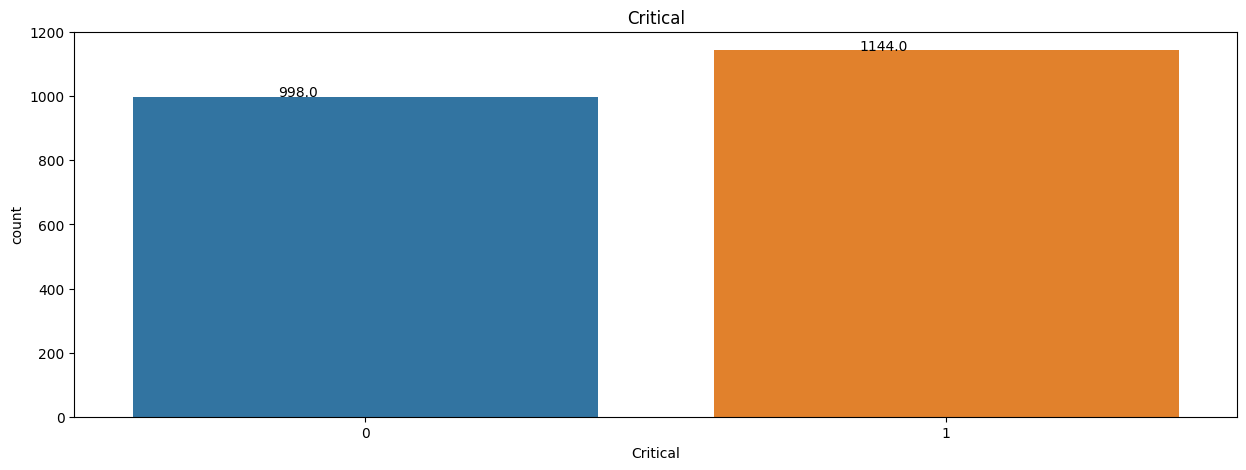

In [310]:
fig , ax = plt.subplots(figsize=(15,5))
ax =sns.countplot(x=labelCol, data=df,)
for p in ax.patches:
   ax.annotate('{:.1f}'.format(p.get_height()), (p.get_x()+0.25, p.get_height()+0.01))
plt.title(labelCol.title())
plt.show()

In [311]:
df.tail()

,sla,product_type,brand,service_type,incident_type,open_to_close_hour,response_to_resolved_hour,Critical
2137,24x7 4Hrs Response Time,Software,Trend Micro,Request,General Incident,308.166667,308.033333,0
2138,24x7 4Hrs Response Time,Software,Trend Micro,Request,Configuration Change,5.516667,5.416667,0
2139,24x7 4Hrs Response Time,Software,Trend Micro,Request,General Incident,168.150000,164.666667,0
2140,24x7 4Hrs Response Time,Software,Trend Micro,Request,General Incident,163.850000,163.850000,0
2141,24x7 6Hrs Resolution Time,Software,Trend Micro,Request,General Incident,5.483333,5.483333,0


In [312]:
len_all=len(df)
print(f"All Data = {len_all}")

train, val = train_test_split(df,test_size=0.2)
val,test = train_test_split(val, test_size=0.5)

len_all=len(df)
len_train=len(train)
len_val=len(val)
len_test=len(test)
print(f'{len_train} =train examples ({round(len_train/len_all*100,1)}%)')
print(f'{len_val} =val examples ({round(len_val/len_all*100,1)}%)')
print(f'{len_test} =test examples ({round(len_test/len_all*100,1)}%)')




All Data = 2142
1713 =train examples (80.0%)
214 =val examples (10.0%)
215 =test examples (10.0%)


In [313]:
# A utility method to create a tf.data dataset from a Pandas Dataframe
def df_to_dataset(dataframe, shuffle=True, batch_size=32):
  dataframe = dataframe.copy()
  labels = dataframe.pop(labelCol)
  ds = tf.data.Dataset.from_tensor_slices((dict(dataframe), labels))
  if shuffle:
    ds = ds.shuffle(buffer_size=len(dataframe))
  ds = ds.batch(batch_size)
  ds = ds.prefetch(batch_size)
  return ds
     

In [314]:
batch_size = 10
train_ds = df_to_dataset(train, batch_size=batch_size)

In [315]:
[(train_features, label_batch)] = train_ds.take(1)
print('Every feature:', list(train_features.keys()))
print('service_type:', train_features['service_type'])
print('incident_type:', train_features['incident_type'])
print('product_type:', train_features['product_type'])
print('open_to_close_hour:', train_features['open_to_close_hour'])
print(f'{labelCol} :{label_batch }')

Every feature: ['sla', 'product_type', 'brand', 'service_type', 'incident_type', 'open_to_close_hour', 'response_to_resolved_hour']
service_type: tf.Tensor(
[b'Request' b'Incident' b'Incident' b'Incident' b'Incident' b'Request'
 b'Incident' b'Incident' b'Incident' b'Incident'], shape=(10,), dtype=string)
incident_type: tf.Tensor(
[b'General Incident' b'Software' b'General Incident'
 b'System Board Failure' b'Hard Disk Drive Failure'
 b'Configuration Change' b'General Incident' b'General Incident'
 b'General Incident' b'General Incident'], shape=(10,), dtype=string)
product_type: tf.Tensor(
[b'Server' b'Software' b'Software' b'Hardware' b'Storage' b'Server'
 b'Server' b'Other' b'Server' b'Server'], shape=(10,), dtype=string)
open_to_close_hour: tf.Tensor(
[  5.13333333   1.06666667   3.8          3.16666667   8.03333333
  89.15        49.         306.71666667  17.93333333   7.11666667], shape=(10,), dtype=float64)
Critical :[1 1 1 1 1 0 1 0 1 1]


In [316]:
def get_normalization_layer(name, dataset):
  # Create a Normalization layer for our feature.
  normalizer = preprocessing.Normalization(axis=None)

  # Prepare a Dataset that only yields our feature.
  feature_ds = dataset.map(lambda x, y: x[name])

  # Learn the statistics of the data.
  normalizer.adapt(feature_ds)

  return normalizer

In [317]:
hour_col = train_features['open_to_close_hour']
layer = get_normalization_layer('open_to_close_hour', train_ds)
layer(hour_col)

<tf.Tensor: shape=(10,), dtype=float32, numpy=
array([-0.3493588 , -0.36430478, -0.3542591 , -0.35658678, -0.33870056,
       -0.0405768 , -0.18813796,  0.7590344 , -0.30231562, -0.34206954],
      dtype=float32)>

In [318]:
def get_category_encoding_layer(name, dataset, dtype, max_tokens=None):
  # Create a StringLookup layer which will turn strings into integer indices
  if dtype == 'string':
    index = preprocessing.StringLookup(max_tokens=max_tokens)
  else:
    index = preprocessing.IntegerLookup(max_tokens=max_tokens)

  # Prepare a Dataset that only yields our feature
  feature_ds = dataset.map(lambda x, y: x[name])

  # Learn the set of possible values and assign them a fixed integer index.
  index.adapt(feature_ds)

  # Create a Discretization for our integer indices.
  encoder = preprocessing.CategoryEncoding(num_tokens=index.vocabulary_size())

  # Apply one-hot encoding to our indices. The lambda function captures the
  # layer so we can use them, or include them in the functional model later.
  return lambda feature: encoder(index(feature))
     

In [319]:
# total no type+unkonw
type_col = train_features['product_type']
layer = get_category_encoding_layer('product_type', train_ds, 'string')
layer(type_col)

<tf.Tensor: shape=(11,), dtype=float32, numpy=array([0., 1., 1., 1., 1., 0., 1., 0., 0., 0., 0.], dtype=float32)>

In [320]:
batch_size =32
train_ds = df_to_dataset(train, batch_size=batch_size)
val_ds = df_to_dataset(val, shuffle=False, batch_size=batch_size)
test_ds = df_to_dataset(test, shuffle=False, batch_size=batch_size)

In [321]:
all_inputs = []
encoded_features = []

In [322]:
# Numeric features.
for header in numbericCols:
  print(header)  
  numeric_col = tf.keras.Input(shape=(1,), name=header)
  normalization_layer = get_normalization_layer(header, train_ds)
  encoded_numeric_col = normalization_layer(numeric_col)
  all_inputs.append(numeric_col)
  encoded_features.append(encoded_numeric_col)

open_to_close_hour
response_to_resolved_hour


In [323]:
# Categorical features encoded as string.
categorical_cols = cateCols
for header in categorical_cols:
  print(header)  
  categorical_col = tf.keras.Input(shape=(1,), name=header, dtype='string')
  encoding_layer = get_category_encoding_layer(header, train_ds, dtype='string')
                                        
  encoded_categorical_col = encoding_layer(categorical_col)
  all_inputs.append(categorical_col)
  encoded_features.append(encoded_categorical_col)


sla
product_type
brand
service_type
incident_type


In [324]:
all_features = tf.keras.layers.concatenate(encoded_features)

x = tf.keras.layers.Dense(16, activation="relu")(all_features)
# x = tf.keras.layers.Dropout(0.2)(x)

x = tf.keras.layers.Dense(16, activation="relu")(x)
# x = tf.keras.layers.Dropout(0.2)(x)

output = tf.keras.layers.Dense(1)(x)
# output = tf.keras.layers.Dense(nLabel,activation=tf.nn.softmax)(x)

model = tf.keras.Model(all_inputs, output)


# METRICS = [
#       keras.metrics.TruePositives(name='tp'),
#       keras.metrics.FalsePositives(name='fp'),
#       keras.metrics.TrueNegatives(name='tn'),
#       keras.metrics.FalseNegatives(name='fn'), 
#       keras.metrics.BinaryAccuracy(name='accuracy'),
#       keras.metrics.Precision(name='precision'),
#       keras.metrics.Recall(name='recall'),
#       keras.metrics.AUC(name='auc'),
# ]


model.compile(optimizer='adam',
              loss=tf.keras.losses.BinaryCrossentropy(from_logits=True),
              metrics=["accuracy"])

# model.compile(optimizer='adam',
#               loss=tf.keras.losses.CategoricalCrossentropy(),
#               metrics=["accuracy"])
     

In [325]:
model.summary()


Model: "model_9"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 sla (InputLayer)               [(None, 1)]          0           []                               
                                                                                                  
 product_type (InputLayer)      [(None, 1)]          0           []                               
                                                                                                  
 brand (InputLayer)             [(None, 1)]          0           []                               
                                                                                                  
 service_type (InputLayer)      [(None, 1)]          0           []                               
                                                                                            

In [326]:
EPOCHS = 100
BATCH_SIZE = 32


# early_stopping = tf.keras.callbacks.EarlyStopping(monitor='val_loss', patience=6, verbose=1)
# history =model.fit(train_ds, validation_data=val_ds,epochs=EPOCHS,batch_size=BATCH_SIZE,callbacks = [early_stopping])
history =model.fit(train_ds, validation_data=val_ds,epochs=EPOCHS,batch_size=BATCH_SIZE)


Epoch 1/100
54/54 [==============================] - 3s 16ms/step - loss: 0.6765 - accuracy: 0.4694 - val_loss: 0.6453 - val_accuracy: 0.4579
Epoch 2/100
54/54 [==============================] - 0s 4ms/step - loss: 0.6140 - accuracy: 0.5593 - val_loss: 0.5808 - val_accuracy: 0.6776
Epoch 3/100
54/54 [==============================] - 0s 4ms/step - loss: 0.5451 - accuracy: 0.7093 - val_loss: 0.5173 - val_accuracy: 0.7383
Epoch 4/100
54/54 [==============================] - 0s 5ms/step - loss: 0.4901 - accuracy: 0.7513 - val_loss: 0.4847 - val_accuracy: 0.7290
Epoch 5/100
54/54 [==============================] - 0s 4ms/step - loss: 0.4620 - accuracy: 0.7630 - val_loss: 0.4712 - val_accuracy: 0.7383
Epoch 6/100
54/54 [==============================] - 0s 5ms/step - loss: 0.4464 - accuracy: 0.7840 - val_loss: 0.4621 - val_accuracy: 0.7570
Epoch 7/100
54/54 [==============================] - 0s 4ms/step - loss: 0.4360 - accuracy: 0.7869 - val_loss: 0.4578 - val_accuracy: 0.7570
Epoch 8/100


In [330]:
loss, accuracy = model.evaluate(test_ds)
print("Accuracy", accuracy)
     

7/7 [==============================] - 0s 3ms/step - loss: 0.5514 - accuracy: 0.7535
Accuracy 0.7534883618354797


In [331]:
tf.keras.utils.plot_model(model, show_shapes=True, rankdir="LR")

You must install pydot (`pip install pydot`) and install graphviz (see instructions at https://graphviz.gitlab.io/download/) for plot_model to work.


In [332]:
model.save(model_dir)


INFO:tensorflow:Assets written to: critical_incident_dnn\assets


INFO:tensorflow:Assets written to: critical_incident_dnn\assets


In [302]:
reloaded_model = tf.keras.models.load_model(model_dir)
print(sr_predict)
sample=sr_predict.to_dict()
input_dict = {name: tf.convert_to_tensor([value]) for name, value in sample.items()}
predictions = reloaded_model.predict(input_dict)
print(predictions)
prob = tf.nn.sigmoid(predictions[0])
print(
    "This particular pet had a %.1f percent probability "
    "of getting adopted." % (100 * prob)
)                               

severity_id                                        4
severity_name                               Cosmatic
sla                          24x7 4Hrs Response Time
product_type                                Software
brand                                    Trend Micro
service_type                                 Request
incident_type                   Configuration Change
open_to_close_hour                          4.066667
response_to_resolved_hour                       4.05
Name: 2142, dtype: object


D:\ProgramData\Anaconda3\envs\dev_google\lib\site-packages\keras\engine\functional.py:638: UserWarning: Input dict contained keys ['severity_id', 'severity_name'] which did not match any model input. They will be ignored by the model.
  inputs = self._flatten_to_reference_inputs(inputs)


1/1 [==============================] - 0s 386ms/step
[[-11.003057]]
This particular pet had a 0.0 percent probability of getting adopted.


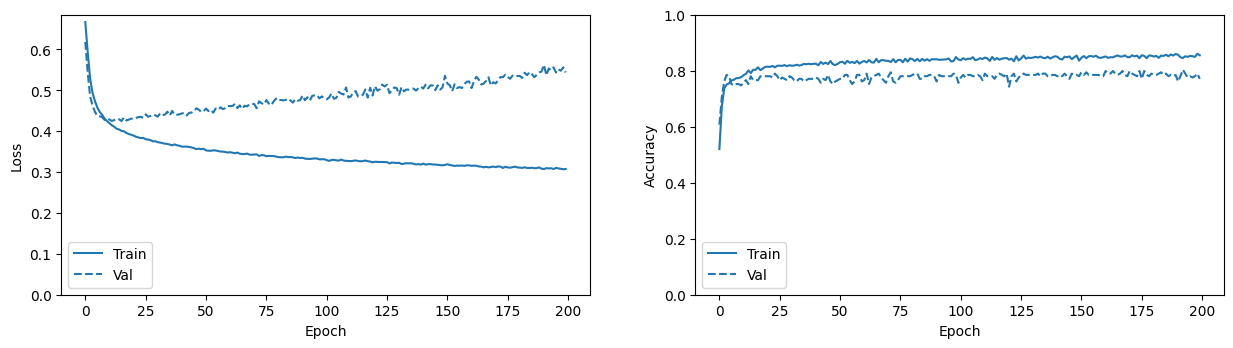

In [303]:
plt.figure(figsize=(15,8))
colors = plt.rcParams['axes.prop_cycle'].by_key()['color']

def plot_metrics(history):
  metrics =  ['loss', 'accuracy']
  for n, metric in enumerate(metrics):
    name = metric.replace("_"," ").capitalize()
    plt.subplot(2,2,n+1)
    plt.plot(history.epoch,  history.history[metric], color=colors[0], label='Train')
    plt.plot(history.epoch, history.history['val_'+metric],
             color=colors[0], linestyle="--", label='Val')
    plt.xlabel('Epoch')
    plt.ylabel(name)
    if metric == 'loss':
      plt.ylim([0, plt.ylim()[1]])
    elif metric == 'auc':
      plt.ylim([0.8,1])
    else:
      plt.ylim([0,1])

    plt.legend()

plot_metrics(history)

In [273]:
# from explainable_ai_sdk.metadata.tf.v2 import SavedModelMetadataBuilder
# import explainable_ai_sdk

# model_builder = SavedModelMetadataBuilder(model_dir)
# metadata = model_builder.get_metadata()
# print(metadata)

In [274]:
# # Update these to your own GCP project and model
# PROJECT_ID = 'pongthorn'
# REGION = "asia-southeast1"  # @param {type: "string"}
# MODEL_BUCKET = 'gs://tf1-incident-pongthorn'

# !gsutil mb -l$REGION $MODEL_BUCKET

In [275]:
# !gsutil -m cp -r ./$model_dir/* $MODEL_BUCKET/model

# Deploy the model

In [385]:
# MODEL = 'tf1_incident'
# VERSION = 'v1'
# model_path = MODEL_BUCKET + '/model'

In [392]:
# !gcloud ai-platform models create $MODEL --region=$REGION